## Data 255 - HomeWork - 10 - Transfomer



#### Torch Text 0.18 is incompatible with Latest Torch Versions. So downgrading Torch to version 2.3.0 so that is works with Torch Text

In [1]:
#!pip uninstall -q -y torch torchtext

In [2]:
#!pip install -q torch==2.3.0 torchtext==0.18.0 torchdata portalocker==2.10.0

In [3]:
#!pip install -q transformers==4.37.2

In [4]:
import time
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchtext
from torchtext.datasets import SQuAD2
from pathlib import Path
from transformers import BertForQuestionAnswering
from transformers import AdamW
import transformers
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
print(torchtext.__version__)
print(f"Transformers version: {transformers.__version__}")

cuda:0
2.3.0+cu121
0.18.0+cpu
Transformers version: 4.37.2


### Step 1. Load the SQUAD 2.0 dataset from pytorch dataset library. Take minimum 20 QnA pairs.

In [6]:
def load_squad_data(data_split, num_samples=20):
    data_iter = SQuAD2(split=data_split)
    texts = []
    questions = []
    answers = []
    answer_starts = []
    answer_ends = []
    for count, (context, question, answer_texts, answer_start_positions) in enumerate(data_iter):
        if count > num_samples:
            break
        ## Skipping Questions with Blank Answers as it is causing problems with Tokenization
        # if not answer_texts or not answer_start_positions or -1 in answer_start_positions:
            # print(f'{question}-{answer_texts}-{answer_start_positions}')
        #    continue
        for answer_text, answer_start in zip(answer_texts, answer_start_positions):
            answer_end = answer_start + len(answer_text)
            texts.append(context)
            questions.append(question)
            answers.append(answer_text)
            answer_starts.append(answer_start)
            answer_ends.append(answer_end)
        count += 1
    return texts, questions, answers, answer_starts, answer_ends

### Step 2. Display a few raw QnA data samples.

In [7]:
train_contexts, train_questions, train_answers, train_answer_starts, train_answer_ends = load_squad_data("train",2000)
for i in range(5):
    print(f"Context: {train_contexts[i]}")
    print(f"Question: {train_questions[i]}")
    print(f"Answer: {train_answers[i]}")
    print(f"Answer Start: {train_answer_starts[i]}")
    print(f"Answer End: {train_answer_ends[i]}")
    print("----")

/usr/local/lib/python3.10/dist-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Question: When did Beyonce start becoming popular?
Answer: in the late 1990s
Answer Start: 269
Answer End: 286
----
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houst

In [8]:
val_contexts, val_questions, val_answers, val_answer_starts, val_answer_ends = load_squad_data("dev",500)
for i in range(5):
    print(f"Context: {val_contexts[i]}")
    print(f"Question: {val_questions[i]}")
    print(f"Answer: {val_answers[i]}")
    print(f"Answer Start: {val_answer_starts[i]}")
    print(f"Answer End: {val_answer_ends[i]}")
    print("----")

Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Question: In what country is Normandy located?
Answer: France
Answer Start: 159
Answer End: 165
----
Context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to N

In [9]:
len(val_contexts)

976

In [10]:
len(train_contexts)

2001

### Step 3. Preprocess/Clean dataset as per BERT format.

#### Validate if any Questions have NULL answers as we don't want to include them in our training and validation sets. SQUAD 2 Dataset has lot of questions with missing answers

In [11]:
count_negative_answer_starts = sum(1 for start in train_answer_starts if start == -1)
print(f"Number of records with val_answer_starts as -1: {count_negative_answer_starts}")

Number of records with val_answer_starts as -1: 0


In [12]:
count_negative_answer_starts = sum(1 for start in val_answer_starts if start == -1)
print(f"Number of records with val_answer_starts as -1: {count_negative_answer_starts}")

Number of records with val_answer_starts as -1: 263


#### Tokenize the contexts and questions using pre-trained bert tokenizer

In [13]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
#Setting up Tokenizer Parameters
TRUNC = "only_second"
PAD = "max_length"
MAX_LENGTH = 384
STRIDE = 128
RET_TENSORS = "pt"

In [15]:
train_encodings = tokenizer(
    train_questions,
    train_contexts,
    truncation=TRUNC,
    padding=PAD,
    max_length=MAX_LENGTH,
    stride=STRIDE,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    return_tensors=RET_TENSORS
)

In [16]:
val_encodings = tokenizer(
    val_questions,
    val_contexts,
    truncation=TRUNC,
    padding=PAD,
    max_length=MAX_LENGTH,
    stride=STRIDE,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    return_tensors=RET_TENSORS
)

In [17]:
print("Keys in train_encodings:", train_encodings.keys())

Keys in train_encodings: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])


In [18]:
print("Keys in train_encodings:", val_encodings.keys())

Keys in train_encodings: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])


#### Convert the start-end positions to tokens start-end positions

In [19]:
def add_token_positions(encodings, contexts, answers, answer_starts, tokenizer):
    sample_mapping = encodings.pop("overflow_to_sample_mapping")
    offset_mapping = encodings.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sample_index = sample_mapping[i]
        answer_start = answer_starts[sample_index]
        answer_text = answers[sample_index]
        input_ids = encodings['input_ids'][i]
        cls_index = input_ids.tolist().index(tokenizer.cls_token_id)

        if answer_start == -1:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answer_start
            end_char = start_char + len(answer_text)

            sequence_ids = encodings.sequence_ids(i)
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            if offsets[token_start_index][0] > end_char or offsets[token_end_index][1] < start_char:
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_position = token_start_index - 1

                while token_end_index >= 0 and offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_position = token_end_index + 1

                start_positions.append(start_position)
                end_positions.append(end_position)

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return encodings

In [20]:
train_encodings = add_token_positions(
    train_encodings,
    train_contexts,
    train_answers,
    train_answer_starts,
    tokenizer
)

In [21]:
val_encodings = add_token_positions(
    val_encodings,
    val_contexts,
    val_answers,
    val_answer_starts,
    tokenizer
)

#### Validation that data is converted to Bert format

In [22]:
print("Sample Training Data:")
print(f"Start Token Position: {train_encodings['start_positions'][0]}")
print(f"End Token Position: {train_encodings['end_positions'][0]}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][0])}")

Sample Training Data:
Start Token Position: 75
End Token Position: 78
Tokens: ['[CLS]', 'when', 'did', 'beyonce', 'start', 'becoming', 'popular', '?', '[SEP]', 'beyonce', 'gi', '##selle', 'knowles', '-', 'carter', '(', '/', 'bi', '##ː', '##ˈ', '##j', '##ɒ', '##nse', '##ɪ', '/', 'bee', '-', 'yo', '##n', '-', 'say', ')', '(', 'born', 'september', '4', ',', '1981', ')', 'is', 'an', 'american', 'singer', ',', 'songwriter', ',', 'record', 'producer', 'and', 'actress', '.', 'born', 'and', 'raised', 'in', 'houston', ',', 'texas', ',', 'she', 'performed', 'in', 'various', 'singing', 'and', 'dancing', 'competitions', 'as', 'a', 'child', ',', 'and', 'rose', 'to', 'fame', 'in', 'the', 'late', '1990s', 'as', 'lead', 'singer', 'of', 'r', '&', 'b', 'girl', '-', 'group', 'destiny', "'", 's', 'child', '.', 'managed', 'by', 'her', 'father', ',', 'mathew', 'knowles', ',', 'the', 'group', 'became', 'one', 'of', 'the', 'world', "'", 's', 'best', '-', 'selling', 'girl', 'groups', 'of', 'all', 'time', '.', 

In [23]:
print("Sample Validation Data:")
print(f"Start Token Position: {val_encodings['start_positions'][0]}")
print(f"End Token Position: {val_encodings['end_positions'][0]}")
print(f"Tokens: {tokenizer.convert_ids_to_tokens(val_encodings['input_ids'][0])}")

Sample Validation Data:
Start Token Position: 49
End Token Position: 49
Tokens: ['[CLS]', 'in', 'what', 'country', 'is', 'normandy', 'located', '?', '[SEP]', 'the', 'norman', '##s', '(', 'norman', ':', 'no', '##ur', '##man', '##ds', ';', 'french', ':', 'norman', '##ds', ';', 'latin', ':', 'norman', '##ni', ')', 'were', 'the', 'people', 'who', 'in', 'the', '10th', 'and', '11th', 'centuries', 'gave', 'their', 'name', 'to', 'normandy', ',', 'a', 'region', 'in', 'france', '.', 'they', 'were', 'descended', 'from', 'norse', '(', '"', 'norman', '"', 'comes', 'from', '"', 'norse', '##man', '"', ')', 'raiders', 'and', 'pirates', 'from', 'denmark', ',', 'iceland', 'and', 'norway', 'who', ',', 'under', 'their', 'leader', 'roll', '##o', ',', 'agreed', 'to', 'swear', 'fe', '##al', '##ty', 'to', 'king', 'charles', 'iii', 'of', 'west', 'fran', '##cia', '.', 'through', 'generations', 'of', 'assimilation', 'and', 'mixing', 'with', 'the', 'native', 'frankish', 'and', 'roman', '-', 'gaul', '##ish', 'popu

## Step 4: Train the BERT QnA model. Evaluate the model.

In [24]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [25]:
train_dataset = CreateDataset(train_encodings)
val_dataset = CreateDataset(val_encodings)

In [26]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [27]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
optim = AdamW(model.parameters(), lr=5e-5)
epochs = 5

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
len(train_loader)

257

In [30]:
len(val_loader)

124

In [31]:
def train_one_epoch(model, train_loader, optimizer, device, log_frequency=10):
    model.train()
    total_train_loss = 0

    for batch_idx, data_batch in enumerate(tqdm(train_loader, desc="Training", ncols=100)):
        optimizer.zero_grad()

        input_ids = data_batch['input_ids'].to(device)
        attention_mask = data_batch['attention_mask'].to(device)
        start_pos = data_batch['start_positions'].to(device)
        end_pos = data_batch['end_positions'].to(device)

        predictions = model(input_ids, attention_mask=attention_mask, start_positions=start_pos, end_positions=end_pos)
        batch_loss = predictions[0]

        batch_loss.backward()
        optimizer.step()

        total_train_loss += batch_loss.item()

        if (batch_idx + 1) % log_frequency == 0:
            print(f"Batch {batch_idx + 1}/{len(train_loader)} Loss: {round(batch_loss.item(), 2)}")

    avg_train_loss = total_train_loss / len(train_loader)
    return avg_train_loss

In [32]:
def evaluate_one_epoch(model, val_loader, device, log_frequency=10):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch_idx, data_batch in enumerate(tqdm(val_loader, desc="Validation", ncols=100)):
            input_ids = data_batch['input_ids'].to(device)
            attention_mask = data_batch['attention_mask'].to(device)
            start_pos = data_batch['start_positions'].to(device)
            end_pos = data_batch['end_positions'].to(device)

            predictions = model(input_ids, attention_mask=attention_mask, start_positions=start_pos, end_positions=end_pos)
            batch_loss = predictions[0]

            total_val_loss += batch_loss.item()

            if (batch_idx + 1) % log_frequency == 0:
                print(f"Batch Count: {batch_idx + 1}/{len(val_loader)} Validation Loss: {round(batch_loss.item(), 2)}")

    avg_val_loss = total_val_loss / len(val_loader)
    return avg_val_loss

In [33]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, device, epochs, log_frequency=10):
    total_time = time.time()
    train_losses = []
    val_losses = []

    for epoch_num in range(epochs):
        print(f"===== Epoch {epoch_num + 1}/{epochs} =====")
        epoch_start_time = time.time()
        print("-----> Training")
        train_loss = train_one_epoch(model, train_loader, optimizer, device, log_frequency)
        train_losses.append(train_loss)
        print("-----> Validation")
        val_loss = evaluate_one_epoch(model, val_loader, device, log_frequency)
        val_losses.append(val_loss)

        print(f"\n--- Epoch {epoch_num + 1} Summary ---"
              f"\nTraining Loss: {train_loss}"
              f"\nValidation Loss: {val_loss}"
              f"\nTime Taken: {round(time.time() - epoch_start_time, 2)} seconds"
              f"\n-------------------------------\n")

    print(f"Total Training and Evaluation Time: {round(time.time() - total_time, 2)} seconds")
    return {"train_losses": train_losses, "val_losses": val_losses}

In [34]:
metrics = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optim,
    device=device,
    epochs=epochs,
    log_frequency=50
)

# Plotting metrics
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']

===== Epoch 1/5 =====
-----> Training


Training:   0%|                                                             | 0/257 [00:00<?, ?it/s]<ipython-input-24-a8608bdc7753>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training:  19%|██████████                                          | 50/257 [00:30<02:02,  1.69it/s]

Batch 50/257 Loss: 3.62


Training:  39%|███████████████████▊                               | 100/257 [00:58<01:28,  1.77it/s]

Batch 100/257 Loss: 3.05


Training:  58%|█████████████████████████████▊                     | 150/257 [01:26<01:00,  1.77it/s]

Batch 150/257 Loss: 2.44


Training:  78%|███████████████████████████████████████▋           | 200/257 [01:55<00:32,  1.75it/s]

Batch 200/257 Loss: 2.05


Training:  97%|█████████████████████████████████████████████████▌ | 250/257 [02:23<00:03,  1.77it/s]

Batch 250/257 Loss: 2.26


Training: 100%|███████████████████████████████████████████████████| 257/257 [02:27<00:00,  1.74it/s]


-----> Validation


Validation:  41%|████████████████████▌                             | 51/124 [00:10<00:14,  5.10it/s]

Batch Count: 50/124 Validation Loss: 3.34


Validation:  81%|███████████████████████████████████████▉         | 101/124 [00:19<00:04,  5.10it/s]

Batch Count: 100/124 Validation Loss: 1.14


Validation: 100%|█████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.10it/s]



--- Epoch 1 Summary ---
Training Loss: 2.9769770973851246
Validation Loss: 3.029355332736046
Time Taken: 171.8 seconds
-------------------------------

===== Epoch 2/5 =====
-----> Training


Training:  19%|██████████                                          | 50/257 [00:28<01:57,  1.76it/s]

Batch 50/257 Loss: 1.32


Training:  39%|███████████████████▊                               | 100/257 [00:56<01:29,  1.76it/s]

Batch 100/257 Loss: 1.41


Training:  58%|█████████████████████████████▊                     | 150/257 [01:25<01:01,  1.75it/s]

Batch 150/257 Loss: 0.24


Training:  78%|███████████████████████████████████████▋           | 200/257 [01:53<00:32,  1.77it/s]

Batch 200/257 Loss: 2.19


Training:  97%|█████████████████████████████████████████████████▌ | 250/257 [02:21<00:03,  1.76it/s]

Batch 250/257 Loss: 1.37


Training: 100%|███████████████████████████████████████████████████| 257/257 [02:25<00:00,  1.76it/s]


-----> Validation


Validation:  41%|████████████████████▌                             | 51/124 [00:10<00:14,  5.11it/s]

Batch Count: 50/124 Validation Loss: 4.73


Validation:  81%|███████████████████████████████████████▉         | 101/124 [00:19<00:04,  5.08it/s]

Batch Count: 100/124 Validation Loss: 1.17


Validation: 100%|█████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.10it/s]



--- Epoch 2 Summary ---
Training Loss: 1.193715006634883
Validation Loss: 3.804962920325418
Time Taken: 169.94 seconds
-------------------------------

===== Epoch 3/5 =====
-----> Training


Training:  19%|██████████                                          | 50/257 [00:28<01:57,  1.77it/s]

Batch 50/257 Loss: 0.29


Training:  39%|███████████████████▊                               | 100/257 [00:56<01:28,  1.76it/s]

Batch 100/257 Loss: 0.45


Training:  58%|█████████████████████████████▊                     | 150/257 [01:25<01:00,  1.76it/s]

Batch 150/257 Loss: 0.4


Training:  78%|███████████████████████████████████████▋           | 200/257 [01:53<00:32,  1.76it/s]

Batch 200/257 Loss: 1.07


Training:  97%|█████████████████████████████████████████████████▌ | 250/257 [02:21<00:03,  1.76it/s]

Batch 250/257 Loss: 0.36


Training: 100%|███████████████████████████████████████████████████| 257/257 [02:25<00:00,  1.77it/s]


-----> Validation


Validation:  41%|████████████████████▌                             | 51/124 [00:10<00:14,  5.07it/s]

Batch Count: 50/124 Validation Loss: 5.48


Validation:  81%|███████████████████████████████████████▉         | 101/124 [00:19<00:04,  5.07it/s]

Batch Count: 100/124 Validation Loss: 0.49


Validation: 100%|█████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.08it/s]



--- Epoch 3 Summary ---
Training Loss: 0.6076954053968538
Validation Loss: 4.234656792975241
Time Taken: 169.82 seconds
-------------------------------

===== Epoch 4/5 =====
-----> Training


Training:  19%|██████████                                          | 50/257 [00:28<01:57,  1.76it/s]

Batch 50/257 Loss: 0.15


Training:  39%|███████████████████▊                               | 100/257 [00:56<01:28,  1.77it/s]

Batch 100/257 Loss: 0.07


Training:  58%|█████████████████████████████▊                     | 150/257 [01:24<01:00,  1.77it/s]

Batch 150/257 Loss: 0.18


Training:  78%|███████████████████████████████████████▋           | 200/257 [01:53<00:32,  1.76it/s]

Batch 200/257 Loss: 1.12


Training:  97%|█████████████████████████████████████████████████▌ | 250/257 [02:21<00:03,  1.76it/s]

Batch 250/257 Loss: 0.44


Training: 100%|███████████████████████████████████████████████████| 257/257 [02:25<00:00,  1.77it/s]


-----> Validation


Validation:  41%|████████████████████▌                             | 51/124 [00:10<00:14,  5.09it/s]

Batch Count: 50/124 Validation Loss: 6.22


Validation:  81%|███████████████████████████████████████▉         | 101/124 [00:19<00:04,  5.09it/s]

Batch Count: 100/124 Validation Loss: 0.95


Validation: 100%|█████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.09it/s]



--- Epoch 4 Summary ---
Training Loss: 0.3949670562093012
Validation Loss: 4.85736351478244
Time Taken: 169.78 seconds
-------------------------------

===== Epoch 5/5 =====
-----> Training


Training:  19%|██████████                                          | 50/257 [00:28<01:57,  1.76it/s]

Batch 50/257 Loss: 0.06


Training:  39%|███████████████████▊                               | 100/257 [00:56<01:28,  1.77it/s]

Batch 100/257 Loss: 0.2


Training:  58%|█████████████████████████████▊                     | 150/257 [01:24<01:00,  1.76it/s]

Batch 150/257 Loss: 0.52


Training:  78%|███████████████████████████████████████▋           | 200/257 [01:53<00:32,  1.76it/s]

Batch 200/257 Loss: 0.14


Training:  97%|█████████████████████████████████████████████████▌ | 250/257 [02:21<00:03,  1.76it/s]

Batch 250/257 Loss: 0.71


Training: 100%|███████████████████████████████████████████████████| 257/257 [02:25<00:00,  1.77it/s]


-----> Validation


Validation:  41%|████████████████████▌                             | 51/124 [00:10<00:14,  5.11it/s]

Batch Count: 50/124 Validation Loss: 7.15


Validation:  81%|███████████████████████████████████████▉         | 101/124 [00:19<00:04,  5.09it/s]

Batch Count: 100/124 Validation Loss: 1.2


Validation: 100%|█████████████████████████████████████████████████| 124/124 [00:24<00:00,  5.11it/s]


--- Epoch 5 Summary ---
Training Loss: 0.28319769621199786
Validation Loss: 4.6621826690050865
Time Taken: 169.68 seconds
-------------------------------

Total Training and Evaluation Time: 851.03 seconds


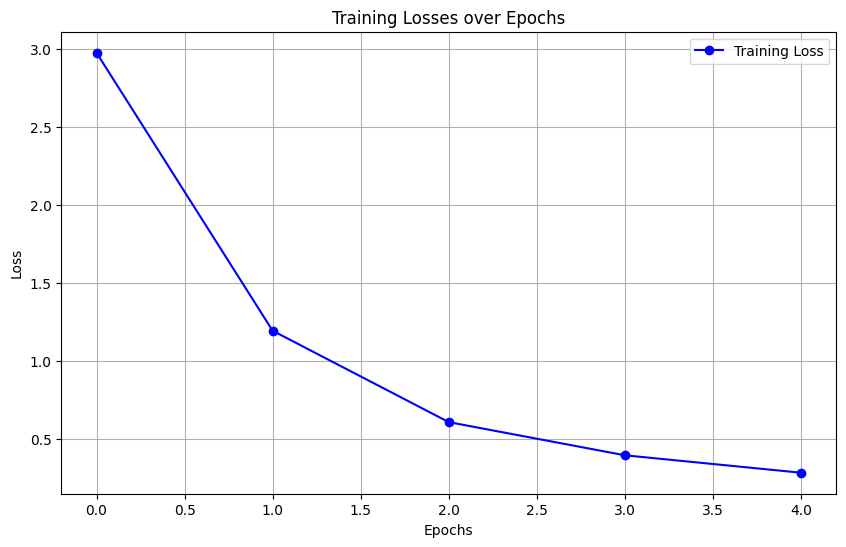

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='b', linestyle='-', marker='o')
plt.title('Training Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Step 5: Perform an Inference and show the predicted vs ground truth answers.

In [36]:
def get_prediction(context_text, question_text):
    encoded_inputs = tokenizer.encode_plus(question_text, context_text, return_tensors='pt')
    encoded_inputs = encoded_inputs.to(device)

    output_scores = model(**encoded_inputs)
    start_idx = torch.argmax(output_scores[0])
    end_idx = torch.argmax(output_scores[1]) + 1

    predicted_answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(encoded_inputs['input_ids'][0][start_idx:end_idx])
    )

    return predicted_answer

In [37]:
def clean_text(text):
    import re, string
    def remove_articles(input_text):
        return re.sub(r"\b(a|an|the)\b", " ", input_text, flags=re.UNICODE)
    def remove_punctuation(input_text):
        return "".join(char for char in input_text if char not in string.punctuation)
    def fix_whitespace(input_text):
        return " ".join(input_text.split())
    def to_lowercase(input_text):
        return input_text.lower()

    return fix_whitespace(remove_articles(remove_punctuation(to_lowercase(text))))

In [38]:
def calculate_exact_match(predicted, actual):
    return int(clean_text(predicted) == clean_text(actual))

In [39]:
def calculate_f1_score(predicted, actual):
    predicted_tokens = clean_text(predicted).split()
    actual_tokens = clean_text(actual).split()

    if not predicted_tokens or not actual_tokens:
        return int(predicted_tokens == actual_tokens)
    shared_tokens = set(predicted_tokens) & set(actual_tokens)

    if not shared_tokens:
        return 0

    precision = len(shared_tokens) / len(predicted_tokens)
    recall = len(shared_tokens) / len(actual_tokens)
    return 2 * (precision * recall) / (precision + recall)

In [40]:
def give_an_answer(context,query,true_answer):
    predicted_answer = get_prediction(context,query)
    exact_match_score = calculate_exact_match(predicted_answer, true_answer)
    f1_score = calculate_f1_score(predicted_answer, true_answer)
    print(f"Actual Question: {query}")
    print("===========================")
    print(f"Prediction Answer: {predicted_answer}")
    print(f"True Answer: {true_answer}")
    exact_match = ''
    if exact_match_score == 0:
      exact_match = 'No'
    else:
      exact_match = 'Yes'
    print(f"Exact Match Score: {exact_match}")
    print(f"F1: {f1_score}")
    print("\n")

#### Performing Inference on some sample data from the Training Dataset from SQUAD dataset

In [41]:
data_split = 'train'
squad_data = SQuAD2(split=data_split)

context_dict = {}
for i, sample in enumerate(squad_data):
    context, question, answers, answer_starts = sample
    answer = answers[0]

    if context not in context_dict:
        context_dict[context] = {'questions': [], 'answers': []}

    context_dict[context]['questions'].append(question)
    context_dict[context]['answers'].append(answer)

    if len(context_dict) == 5:
        break

In [42]:
for context, qa in context_dict.items():
    questions = qa['questions']
    answers = qa['answers']
    for ques, ans in zip(questions, answers):
        give_an_answer(context, ques, ans)

Actual Question: When did Beyonce start becoming popular?
Prediction Answer: late 1990s
True Answer: in the late 1990s
Exact Match Score: No
F1: 0.8


Actual Question: What areas did Beyonce compete in when she was growing up?
Prediction Answer: singing and dancing
True Answer: singing and dancing
Exact Match Score: Yes
F1: 1.0


Actual Question: When did Beyonce leave Destiny's Child and become a solo singer?
Prediction Answer: 
True Answer: 2003
Exact Match Score: No
F1: 0


Actual Question: In what city and state did Beyonce  grow up? 
Prediction Answer: houston, texas
True Answer: Houston, Texas
Exact Match Score: Yes
F1: 1.0


Actual Question: In which decade did Beyonce become famous?
Prediction Answer: late 1990s
True Answer: late 1990s
Exact Match Score: Yes
F1: 1.0


Actual Question: In what R&B group was she the lead singer?
Prediction Answer: destiny ' s child
True Answer: Destiny's Child
Exact Match Score: No
F1: 0.4


Actual Question: What album made her a worldwide known 

#### Performing Inference on Generic Question and Answers

In [43]:
context = """This is Eshita Gupta, born in India. She is currently a Student at SJSU doing MSDA. Her SJSU ID is 016978741.
              She is in 3rd Semester."""
questions = ["Where was Eshita Born?",
           "What does Eshita do?",
           "What is her SJSU ID?",
           "Which semester is Eshita currently in ?",
          ]
answers = ["India",
           "Student at SJSU",
           "016978741",
           "3rd"
          ]
for ques,ans in zip(questions,answers):
    give_an_answer(context,ques,ans)

Actual Question: Where was Eshita Born?
Prediction Answer: india
True Answer: India
Exact Match Score: Yes
F1: 1.0


Actual Question: What does Eshita do?
Prediction Answer: msda
True Answer: Student at SJSU
Exact Match Score: No
F1: 0


Actual Question: What is her SJSU ID?
Prediction Answer: 016978741
True Answer: 016978741
Exact Match Score: Yes
F1: 1.0


Actual Question: Which semester is Eshita currently in ?
Prediction Answer: 3rd
True Answer: 3rd
Exact Match Score: Yes
F1: 1.0




#### Performing Inference on some sample data from the Validation Dataset from SQUAD dataset¶

In [44]:
data_split = 'dev'
squad_data = SQuAD2(split=data_split)

context_dict = {}
for i, sample in enumerate(squad_data):
    context, question, answers, answer_starts = sample
    answer = answers[0]

    if context not in context_dict:
        context_dict[context] = {'questions': [], 'answers': []}

    context_dict[context]['questions'].append(question)
    context_dict[context]['answers'].append(answer)

    if len(context_dict) == 5:
        break

In [45]:
for context, qa in context_dict.items():
    questions = qa['questions']
    answers = qa['answers']
    for ques, ans in zip(questions, answers):
        give_an_answer(context, ques, ans)

Actual Question: In what country is Normandy located?
Prediction Answer: france
True Answer: France
Exact Match Score: Yes
F1: 1.0


Actual Question: When were the Normans in Normandy?
Prediction Answer: the 10th and 11th centuries
True Answer: 10th and 11th centuries
Exact Match Score: Yes
F1: 1.0


Actual Question: From which countries did the Norse originate?
Prediction Answer: denmark, iceland and norway
True Answer: Denmark, Iceland and Norway
Exact Match Score: Yes
F1: 1.0


Actual Question: Who was the Norse leader?
Prediction Answer: rollo
True Answer: Rollo
Exact Match Score: Yes
F1: 1.0


Actual Question: What century did the Normans first gain their separate identity?
Prediction Answer: 
True Answer: 10th century
Exact Match Score: No
F1: 0


Actual Question: Who gave their name to Normandy in the 1000's and 1100's
Prediction Answer: the normans
True Answer: 
Exact Match Score: No
F1: 0


Actual Question: What is France a region of?
Prediction Answer: normandy
True Answer: 


## Thank You